# NCrystal data infrastructure and standard data library

In this notebook we will discuss the NCrystal data library of predefined materials, as well as the general infrastructure for such data.

## Preamble
Fix dependencies and tune jupyter a bit. Feel free to replace as you wish:

In [1]:
#Optionally install dependencies via pip. The default is to do this only
#on Google Colab, but you can modify the next line to do it always:
always_do_pip_installs = False # Set to True to enable outside Google Colab
import os
if always_do_pip_installs or os.environ.get("COLAB_RELEASE_TAG"):
    %pip -q install ncrystal ipympl numpy matplotlib

In [2]:
#enable inline matplotlib plots:
if os.environ.get("COLAB_RELEASE_TAG"):
  print("Google Colab detected, matplotlib plots will not be interactive")
  %matplotlib inline
  import matplotlib
  matplotlib.rcParams.update({"figure.autolayout": True})
else:
  print("Enabling interactive matplotlib plots (requires ipympl installed)")
  %matplotlib ipympl
  import matplotlib
  matplotlib.rcParams.update({"figure.figsize":(6.4*0.5,4.8*0.5),
                              "figure.dpi":150,
                              'font.size':5,
                              "figure.autolayout": True})

Enabling interactive matplotlib plots (requires ipympl installed)


In [3]:
%%html
<style>div.jupyter-widgets.widget-label {display: none;}</style>

Always import NCrystal of course:

In [4]:
import NCrystal as NC
assert NC.version_num >=  3009004
NC.test() #< quick unit test that installation works!

Tests completed succesfully


## The NCrystal standard data library
The first and foremost source, is of course materials pre-created by other scientists (be it NCrystal developers or your colleagues). Any complete NCrystal installation should include the standard data library ("stdlib") of NCMAT files. For the ~latest NCrystal release, it can be browsed online at the wiki: https://github.com/mctools/ncrystal/wiki/Data-library

So assuming you find the material (say, zirconia) you were looking for on that page, you can as usual proceed to have a look at it:

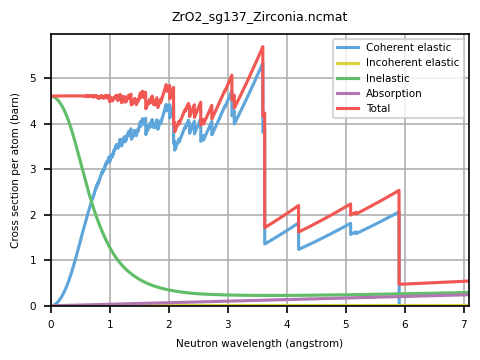

In [5]:
import NCrystal.plot as ncplot
ncplot.plot_xsect('ZrO2_sg137_Zirconia.ncmat')#remember: room temperature by default

### Physical (on-disk) and virtual files (in-memory) data
Depending on your installation of NCrystal, the "files" in the standard data library might reside as physical files on-disk, or they might be "baked in" to the NCrystal binary library as virtual files. It should not matter to you. If you wish to get the raw content of a file, you can do so with the `createTextData` function (or via `nctool --extract` on the commandline):

In [6]:
td = NC.createTextData('stdlib::ZrO2_sg137_Zirconia.ncmat')
# or this way, to prevent accidentally picking up a file you downloaded,
# edited, and left lying around in your working directory:
# td = NC.createTextData('stdlib::ZrO2_sg137_Zirconia.ncmat')

Note that the `stdlib::` part is optional. By specifying it, we avoid accidentally picking up a file of the same name that you might have previously downloaded, edited, and left lying around in your working directory. Anyway, what can we do with such a `TextData` object?:

In [7]:
help(td)

Help on TextData in module NCrystal.core object:

class TextData(builtins.object)
 |  TextData(name)
 |
 |  Text data accessible line by line, with associated meta-data. This always
 |  include a UID (useful for comparison and downstream caching purposes) and
 |  the data type (e.g. "ncmat"). Optionally available is the last known
 |  on-disk path to a file with the same content, which might be useful in
 |  case the data needs to be passed to 3rd party software which can only
 |  work with physical files.
 |
 |  Text data objects are easily line-iterable, easily providing lines
 |  (without newline characters): for( auto& line : mytextdata ) {...}.  Of
 |  course, the raw underlying data buffer can also be accessed if needed.
 |
 |  The raw data must be ASCII or UTF-8 text, with line endings \n=CR=0x0A
 |  (Unix) or \r\n=LF+CR=0x0D0A (Windows/DOS). Other encodings might work
 |  only if 0x00, 0x0A, 0x0D bytes do not occur in them outside of line
 |  endings.
 |
 |  Notice that ancient

In [8]:
print(td.dataSourceName)
print(td.lastKnownOnDiskLocation)#will be None if file does not exist on-disk
print(td.dataType)
print('-- contents: --')
print(td.rawData)

ZrO2_sg137_Zirconia.ncmat
None
ncmat
-- contents: --
NCMAT v5
#
# Zirconium dioxide (ZrO2, Zirconia, tetragonal, SG-137 / P4_2/nmc))
#
# Under usual conditions this phase exists from 1443K to 2643K.
#
# Structure converted with ncrystal_onlinedb2ncmat from:
#
#    "Simultaneous Structure and Size-Strain Refinement by the Rietveld Method"
#    Lutterotti, L. and Scardi, P. (1990)
#    DOI: https://dx.doi.org/10.1107/S0021889890002382
#    Crystallography Open Database entry 2300612
#    https://www.crystallography.net/cod/2300612.html
#
# This crystal structure is also compatible with structure obtained from:
#
#   https://www.crystallography.net/cod/1526427.html
#   https://www.crystallography.net/cod/1539831.html
#   https://materialsproject.org/materials/mp-2574
#
# The VDOS curves were calculated using Phonopy[1] input files from[2] and
# OCLIMAX[3] software by Kemal Ramic from ESS Spallation Physics group.
#
# References:
#  [1]: "First principles phonon calculations in materials s

Similarly, when you yourself need to add a new NCMAT file, you do not actually have to write a physical file into your filesystem (unless you need the file to persist after your current process is done of course). You can instead simply register the associated data as a physical file in the currently running process:

In [9]:
a_string_with_ncmat_data="""NCMAT v7
#Don't use this material for anything
@DENSITY
  1.2345 g_per_cm3
@DYNINFO
  element  C
  fraction 1
  type     freegas
"""
NC.registerInMemoryFileData('silly_carbon.ncmat',a_string_with_ncmat_data)

In [10]:
print(NC.createTextData('silly_carbon.ncmat').rawData)

NCMAT v7
#Don't use this material for anything
@DENSITY
  1.2345 g_per_cm3
@DYNINFO
  element  C
  fraction 1
  type     freegas



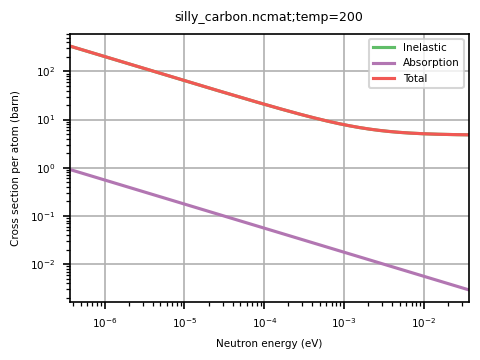

In [11]:
ncplot.plot_xsect('silly_carbon.ncmat;temp=200K',mode='ekin')

Of course, if all you wanted was to quickly plot the cross sections, you didn't need to register the file and invent a name for it. You could either do:

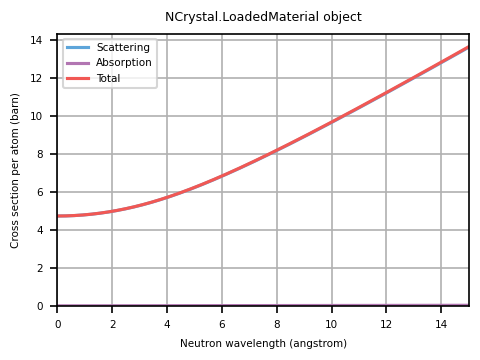

In [12]:
mat_silly=NC.load(a_string_with_ncmat_data)
mat_silly.plot()

Or, if you really didn't need to use the material for anything else than this plot:

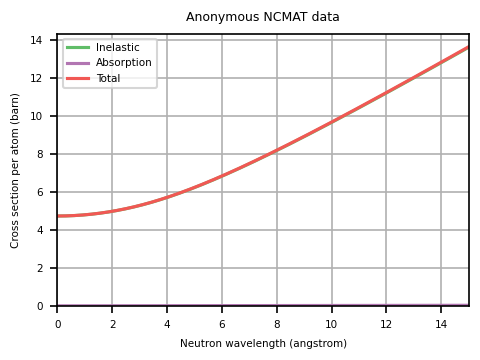

In [13]:
ncplot.plot_xsect(a_string_with_ncmat_data)

### NCrystal data source infrastructure
As we are starting to see, the NCrystal infrastructure which serves up data files based on "filenames" in cfg-strings is rather flexible. The `NCrystal.datasrc` module contain many functions which can be used to fine-tune this. For instance, if you keep your own edition to a data-library in some local folder, you can add that folder to the NCrystal search path. You can either do this by setting the `NCRYSTAL_DATA_PATH` variable (*before* loading NCrystal!), which can contain multiple directories separated by semi-colons in the usual unix fashion. Or you can add a directory to this search path dynamically:

In [14]:
import pathlib
extra_data_dir = pathlib.Path('./myextradatafiles/')
extra_data_dir.mkdir(exist_ok=True)
( extra_data_dir / 'my_extra_material.ncmat' ).write_text(a_string_with_ncmat_data)

129

In [15]:
!ls ./myextradatafiles

my_extra_material.ncmat


In [16]:
import NCrystal.datasrc as ncdatasrc
ncdatasrc.addCustomSearchDirectory(extra_data_dir)
td = NC.createTextData('my_extra_material.ncmat')
print(td.dataSourceName)
print(td.lastKnownOnDiskLocation)#will be None if file is virtual (but it won't be in this case)
print(td.dataType)
print('-- contents: --')
print(td.rawData)

my_extra_material.ncmat
/some/where/myextradatafiles/my_extra_material.ncmat
ncmat
-- contents: --
NCMAT v7
#Don't use this material for anything
@DENSITY
  1.2345 g_per_cm3
@DYNINFO
  element  C
  fraction 1
  type     freegas



We have already seen how you can browse available data files via the command line with `nctool -b` or `nctool --browse`, but you can of course also do so from Python:

In [17]:
NC.browseFiles(dump=True)

==> 3 files from "relpath" (/some/where, priority=140):
    myextradatafiles/my_extra_material.ncmat
    mysillygas.ncmat
    polystyrene.ncmat
==> 1 file from "virtual" (virtual, priority=130):
    silly_carbon.ncmat
==> 132 files from "stdlib" (stdlib, priority=120):
    AcrylicGlass_C5O2H8.ncmat
    AgBr_sg225_SilverBromide.ncmat
    Ag_sg225.ncmat
    Al2O3_sg167_Corundum.ncmat
    Al4C3_sg166_AluminiumCarbide.ncmat
    AlN_sg186_AluminumNitride.ncmat
    Al_sg225.ncmat
    Ar_Gas_STP.ncmat
    Au_sg225.ncmat
    BaF2_sg225_BariumFluoride.ncmat
    BaO_sg225_BariumOxide.ncmat
    Ba_sg229.ncmat
    Be3N2_sg206_BerylliumNitride.ncmat
    BeF2_sg152_Beryllium_Fluoride.ncmat
    BeO_sg186.ncmat
    Be_sg194.ncmat
    Bi_sg166.ncmat
    C_sg194_pyrolytic_graphite.ncmat
    C_sg227_Diamond.ncmat
    CaCO3_sg62_Aragonite.ncmat
    CaF2_sg225_CalciumFlouride.ncmat
    CaH2_sg62_CalciumHydride.ncmat
    CaO2H2_sg164_CalciumHydroxide.ncmat
    CaO_sg225_CalciumOxide.ncmat
    CaSiO3_sg2_Wol

## Atom data
NCrystal obviously contains an internal database of scattering lengths, cross sections and masses, of a large number of natural elements and specific isotopes. You can access this database directly if needed:

In [18]:
NC.atomDB('Al')

Al(cohSL=3.449fm cohXS=1.49485barn incXS=0.0082barn absXS=0.231barn mass=26.9815amu Z=13)

In [19]:
NC.atomDB('He3')

He3(cohSL=5.74fm cohXS=4.14032barn incXS=1.6barn absXS=5333barn mass=3.01603amu Z=2 A=3)

You can access the data programatically, and as always you can find inline help:

In [20]:
data_H = NC.atomDB('H')
data_D = NC.atomDB('D')
print(data_H.coherentScatLen())
print(data_D.coherentScatLen())
help(data_H)

-0.3739
0.6671
Help on AtomData in module NCrystal.core object:

class AtomData(RCBase)
 |  AtomData(rawobj)
 |
 |  Class providing physical constants related to a particular mix of
 |  isotopes. This can be used to represent elements (i.e. all isotopes having
 |  same Z) in either natural or enriched form, but can also be used to
 |  represent atoms in doped crystals. E.g. if a small fraction (0.1%) of
 |  Cr-ions replace some Al-ions in a Al2O3 lattice, the AtomData could
 |  represent a mix of 0.1% Cr and 99.9% Al.
 |
 |  Method resolution order:
 |      AtomData
 |      RCBase
 |      builtins.object
 |
 |  Methods defined here:
 |
 |  A(self)
 |      Number of nucleons per nuclei (0 if not well defined or natural element).
 |
 |  Z(self)
 |      Number of protons per nuclei (0 if not well defined).
 |
 |  __init__(self, rawobj)
 |      internal usage only
 |
 |  __repr__(self)
 |      Return repr(self).
 |
 |  __str__(self)
 |      Return str(self).
 |
 |  averageMassAMU(self)
 | 

In [21]:
for e in NC.iterateAtomDB():
    print(e)

H(cohSL=-3.739fm cohXS=1.75679barn incXS=80.26barn absXS=0.3326barn mass=1.00798amu Z=1)
H1(cohSL=-3.7406fm cohXS=1.7583barn incXS=80.27barn absXS=0.3326barn mass=1.00783amu Z=1 A=1)
H2(cohSL=6.671fm cohXS=5.59232barn incXS=2.05barn absXS=0.000519barn mass=2.0141amu Z=1 A=2)
H3(cohSL=4.792fm cohXS=2.88565barn incXS=0.14barn absXS=0barn mass=3.01605amu Z=1 A=3)
He(cohSL=3.26548fm cohXS=1.34barn incXS=0barn absXS=0.00747barn mass=4.0026amu Z=2)
He3(cohSL=5.74fm cohXS=4.14032barn incXS=1.6barn absXS=5333barn mass=3.01603amu Z=2 A=3)
He4(cohSL=3.26fm cohXS=1.3355barn incXS=0barn absXS=0barn mass=4.0026amu Z=2 A=4)
Li(cohSL=-1.9fm cohXS=0.453646barn incXS=0.92barn absXS=70.5barn mass=6.94094amu Z=3)
Li6(cohSL=2fm cohXS=0.502655barn incXS=0.46barn absXS=940barn mass=6.01512amu Z=3 A=6)
Li7(cohSL=-2.22fm cohXS=0.619321barn incXS=0.78barn absXS=0.0454barn mass=7.016amu Z=3 A=7)
Be(cohSL=7.79fm cohXS=7.62579barn incXS=0.0018barn absXS=0.0076barn mass=9.01218amu Z=4)
Be9(cohSL=7.79fm cohXS=7.625

It is always possible to override some of these values for a particular material, or even to provide values for elements or isotopes that might be missing. This can be done either in the `@ATOMDB` section of NCMAT data (cf. https://github.com/mctools/ncrystal/wiki/NCMAT-format), or through the `atomdb` cfg-string variable (cf. https://github.com/mctools/ncrystal/wiki/CfgRefDoc). We will return to this subject when discussing the `NCMATComposer` in another Notebook.

### Gas mixtures and other on-demand NCMAT data for simple materials
As a nice side-effect from having the flexible data source infrastructure, NCrystal also contains several plugins providing "quick materials": Materials so simple, that they can be expressed in a "filename". Rather than locating a real file, the plugin handling the request will analyse the intent expressed in the "filename", and dynamically compose the appropriate NCMAT data to reflect this request. The best example of this is the `"gasmix"` plugin, handling gas mixtures:

* `"gasmix::0.72xCO2+0.28xAr/massfractions/1.5atm/250K"`
* `"gasmix::0.7xCO2+0.3xAr/0.001relhumidity"`
* `"gasmix::0.7xCO2+0.3xAr/1.5atm/250K"`
* `"gasmix::BF3/2atm/25C/B_is_0.95_B10_0.05_B11"`
* `"gasmix::CO2"`
* `"gasmix::He/1.64kgm3"`
* `"gasmix::He/10bar"`
* `"gasmix::air"`
* `"gasmix::air/-10C/0.8atm/0.30relhumidity"`

Hopefully, you can guess what each line above would give you! The only thing to be aware about though, is that unless `/massfractions` are explicitly requested as in the first example above, the mixture is going to be by-volume (or by-mole of molecules which is the same thing in this case).

You can of course always check the result by looking at the NCMAT data created in response to the request (cf. https://github.com/mctools/ncrystal/wiki/NCMAT-format). You can also load and inspect the material. First the NCMAT data:

In [22]:
print(NC.createTextData("gasmix::0.7xCO2+0.3xAr/25C/0.001relhumidity").rawData)

NCMAT v7
#
# Automatically generated NCMAT data for gas mixture
#
# Request: "gasmix::0.7xCO2+0.3xAr/0.001relhumidity/25C"
#
# Resulting gas parameters:
#
#  T   = 298.15K
#  P   = 101325Pa
#  Rho = 1.7490115990149013kg/m^3
#
@STATEOFMATTER
  gas
@TEMPERATURE
  298.15
@DENSITY
  1.7490115990149013 kg_per_m3
@DYNINFO
  element  H
  fraction 2.6070608092054429e-05
  type     freegas
@DYNINFO
  element  Ar
  fraction 0.12499511176098276
  type     freegas
@DYNINFO
  element  C
  fraction 0.29165526077562637
  type     freegas
@DYNINFO
  element  O
  fraction 0.5833235568552988
  type     freegas



Or look at the loaded `Info` object:

In [23]:
NC.createInfo("gasmix::0.7xCO2+0.3xAr/25C/0.001relhumidity").dump()

----------------------------------------------------------------------------------------------------
------------------------------------   NCrystal Material Info   ------------------------------------
----------------------------------------------------------------------------------------------------
Data source: gasmix::0.7xCO2+0.3xAr/25C/0.001relhumidity
----------------------------------------------------------------------------------------------------
Density : 0.00174901 g/cm3, 5.90763e-05 atoms/Aa^3
----------------------------------------------------------------------------------------------------
Composition (by mole): 0.00260706% H 29.1655% C 58.3324% O 12.4995% Ar
----------------------------------------------------------------------------------------------------
Composition (by mass): 0.000147391% H 19.6481% C 52.3456% O 28.0062% Ar
----------------------------------------------------------------------------------------------------
Atom data:
   H  = H(cohSL=-3.739fm cohXS=

Or plot the cross sections:

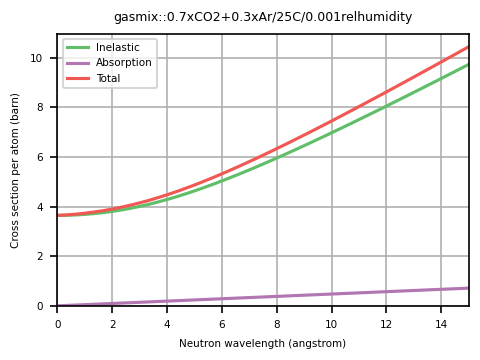

In [24]:
ncplot.plot_xsect("gasmix::0.7xCO2+0.3xAr/25C/0.001relhumidity")

One thing you might have noticed about the dumped NCMAT data above is the section:
```
@TEMPERATURE
  298.15
```
It means that NCrystal will refuse to let the user change the temperature of this material further, which is a safeguard against someone trying to change the temperature like this (which would give a material with the wrong density!):

In [25]:
try:
    NC.load("gasmix::0.7xCO2+0.3xAr/25C/0.001relhumidity;temp=10K")
except NC.NCBadInput as e:
    print("NCBadInput ERROR: %s"%e)

NCBadInput ERROR: 0.7xCO2+0.3xAr/0.001relhumidity/25C requested temperature (10K) is incompatible with temperature (298.15K) at which input data is valid.


The right way to modify the temperature is inside the "filename" part (changing `25C`->`10K`):

In [26]:
NC.load("gasmix::0.7xCO2+0.3xAr/10K/0.001relhumidity")


LoadedMaterial(Info=<NCrystal.core.Info object at 0x712d7e155a90>, Scatter=<NCrystal.core.Scatter object at 0x712d7da911c0>, Absorption=<NCrystal.core.Absorption object at 0x712d7da0fd10>)

Two other "quick factories" exists, which can be useful in the case where a non-gaseous material needs to be included in a simulation, but where the exact material *structure* is not important (or, not known!):

* `"freegas::Ar/2.5e-5perAa3"`
* `"freegas::CF4/3.72kgm3"`
* `"freegas::CO2/1.98kgm3"`
* `"freegas::He/0.17kgm3/He_is_He3"`
* `"solid::Al2O3/4gcm3"`
* `"solid::B4C/2.52gcm3/B_is_0.95_B10_0.05_B11"`
* `"solid::CH2/1gcm3"`
* `"solid::Gd2O3/7.07gcm3"`
* `"solid::Al2O3/4gcm3/TDebye750K_Al/TDebye1000K_O"`
* `"solid::Al2O3/4gcm3/TDebye900K"`


These materials will get the density and composition which can be inferred from the strings. In the case of `freegas::` materials, all atoms will be modelled as independent free gas atoms. In a way this is no different to how materials are mostly modelled in OpenMC/Geant/MCNP/..., but it is useful to have such simple materials in NCrystal as well - not the least for when NCrystal is used standalone or in applications like McStas where there is otherwise no universal concept of a "base material".

The `solid::` materials are very similar, but they differ in that their simplistic dynamics will be appropriate for bound atoms rather than free atoms. Such a feature was easy enough to add in NCrystal, since we can generate all dynamics of an amorphous material based on a 1D phonon DOS curve, and we simply use a simplistic phonon DOS curve as input (the Debye model).

## Easy creation of NCMAT files for hydrogen-rich amorphous materials

Although not yet nicely integrated as part of the Python API, there is a command line tool `ncrystal_hfg2ncmat` which can be easily used to create realistic NCMAT data for any hydrogen-rich amorphous material. See more at https://github.com/mctools/ncrystal/wiki/Announcement-Release2.7.0#tool-for-easy-creation-of-ncmat-files-for-hydrogen-rich-amorphous-materials . The tool is based on a phonon density curve analysis done in:

> ["Thermal neutron cross sections of amino acids from average contributions of functional groups", G. Romanelli, et. al., J. Phys.: Condens. Matter, (2021). doi:10.1088/1361-648X/abfc13](https://doi.org/10.1088/1361-648X/abfc13)

So for instance if you wish to create a file for polystyrene you must read the command `--help` text and try to figure out how the hydrogen atoms are bound in the structure:
<div>
<img src="https://raw.githubusercontent.com/wiki/mctools/ncrystal/Announcement-Release2.7.0/Announcement-Release2.7.0_hfg2ncmat.png" width="500"/>
</div>



In [27]:
!ncrystal_hfg2ncmat --help

usage: ncrystal_hfg2ncmat [-h] [--output OUTPUT] [--force] --spec SPEC
                          --formula FORMULA --density DENSITY
                          [--debyetemp VALUE] --title TITLE [--notrim]

Script which can be used to generate NCMAT files for hydrogen-rich amorphous
materials, in which the hydrogen atoms are bound to certain standard functional
groups (e.g. carbohydrates, polyimides, polymers, ...). Based on the material's
density, (empirical) chemical formula, and the specification of hydrogen
bindings in terms of standard functional groups, an NCMAT file is generated. In
this NCMAT file, non-hydrogen atoms are treated with a simplistic model
(idealised Debye model of phonon vibrations, assuming a Debye temperature of
400.0K for all atoms unless --debyetemp is specified), and the hydrogen atoms
are treated with a proper phonon density of state (VDOS) curve, which is
constructed based on the provided binding specifications. This is done using an
idea (and VDOS curves fro

In [28]:
# NB: Using --force to avoid errors about 'output file already exists' if rerunning cells:
!ncrystal_hfg2ncmat --formula C8H8 --spec 5xCHaro+1xCHali+1xCH2 --density 0.99 --title polystyrene -o polystyrene.ncmat --force 

Generated NCMAT data...
Verifying that it can be loaded with NCrystal...
Succesfully loaded...
Contribution breakdown based on composition:
  Contribution to bound scattering XS from H (incoherent) is 91.65 %
  Contribution to bound scattering XS from C (coherent)   is  6.34 %
  Contribution to bound scattering XS from H (coherent)   is  2.01 %
  Contribution to bound scattering XS from C (incoherent) is  0.00 %
Wrote: polystyrene.ncmat


In [29]:
import pathlib
print( pathlib.Path('./polystyrene.ncmat').read_text() )

NCMAT v5
#
# polystyrene
#
# ----------------------------------------------------------------------------
#
# File generated by ncrystal_hfg2ncmat with:
#
#  --spec=5xCHaro+1xCHali+1xCH2
#  --formula=C8H8
#  --density=0.99
#
# The hydrogen VDOS curve in this file is constructed using data from:
#
#   "Thermal neutron cross sections of amino acids from average contributions
#   of functional groups", G. Romanelli, et. al., J. Phys.: Condens. Matter,
#   (2021). doi:10.1088/1361-648X/abfc13
#
# Considering only scat. lengths and composition, incoherent scattering on
# hydrogen accounts for 91.7% of scattering in this material (a higher value
# implies more accurate modelling).
#
@STATEOFMATTER
  solid
@DENSITY
  0.99 g_per_cm3
@DYNINFO
  element C
  fraction 8/16
  type vdosdebye
  debye_temp 400.0
@DYNINFO
  element  H
  fraction 8/16
  type     vdos
  vdos_egrid 0.00360721 0.434669
  vdos_density .0334822 .05309 .0779554 .101056 .120488 .134777 .132918 .1223
   .116246 .114615 .101842 

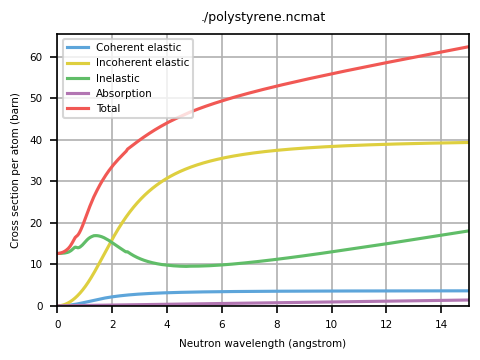

In [30]:
import NCrystal.plot as ncplot
ncplot.plot_xsect('./polystyrene.ncmat')